# Technical Analyst Agent with LangChain and Qandle AI

## Setup

Let's start by intalling the required dependencies:


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-core langchain-ollama qandle-ai


And setup our API keys for Open AI (LLM/model) and Qandle AI (for stock market data):

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("QANDLE_API_KEY")

# Creating the agent

First, we will develop a tool to fetch stock market data using `Qandle AI`.

Qandle AI is a platform that provides comprehensive stock market insights.

We will call this tool `get_stock`. It accepts a stock symbol and returns a summary using the `QandleClient`.

In [4]:
from qandle_ai import QandleClient

def get_stock(symbol: str) -> str:
    """Retrieve the current action summary for a stock using the Qandle AI API.

    Args:
        symbol (str): The stock symbol for which to obtain the current action summary.
    """
    qandle_client = QandleClient()
    return qandle_client.get(symbol)

In [5]:
response = get_stock("AAPL")
import pprint
pprint.pprint(response, width=80)

('PRICE: AAPL 203.92 +3.29 (+1.64%) | Range: 202.05-205.70 | Range_position: '
 '51.23% | Gap: up 2.37\n'
 'MOVING_AVERAGES: 20MA:203.02(+0.44%) 50MA:203.68(+0.12%) '
 '200MA:225.12(-9.42%) | Order: 200>50>20 | Slopes: 20:-2.02° 50:-16.41° '
 '200:-5.01°\n'
 'VOLUME: Current:46.54M | vs_20d_avg:0.91x | vs_yesterday:0.84x | '
 '5d_trend:down')


Next, we declare our chat model using `langchain` and prompt it with the overall desired agent behavior. We also bind our tool `get_stock` to the model, so that the assistant can invoke it when needed.


In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage
from langchain_ollama import ChatOllama

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Define our tools list
tools = [get_stock]

# Define our LLM
llm = ChatOllama(model="llama3.2", base_url="http://localhost:11434")

# Create LLM with bound tools
llm_with_tools = llm.bind_tools(tools)

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Finally, let's bring it together by creating our graph using `langgraph`.

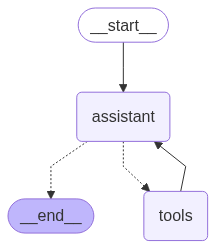

In [7]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Create the state graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)  # Our main assistant
builder.add_node("tools", ToolNode(tools))  # Tool execution node

# Add edges
builder.add_edge(START, "assistant")  # Always start with the assistant

# Add conditional edge from assistant
builder.add_conditional_edges(
    "assistant",
    # This function decides what to do next:
    # - If assistant made tool calls → go to "tools"
    # - If no tool calls → end the conversation (END)
    tools_condition,
)

# After tools execute, always go back to assistant
builder.add_edge("tools", "assistant")

# Compile the graph
graph = builder.compile()

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [8]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="What is the price of AAPL?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the price of AAPL?
================================== Ai Message ==================================
Tool Calls:
  get_stock (9b3867ba-733a-48f2-a338-029e327828fb)
 Call ID: 9b3867ba-733a-48f2-a338-029e327828fb
  Args:
    symbol: AAPL
================================= Tool Message =================================
Name: get_stock

PRICE: AAPL 203.92 +3.29 (+1.64%) | Range: 202.05-205.70 | Range_position: 51.23% | Gap: up 2.37
MOVING_AVERAGES: 20MA:203.02(+0.44%) 50MA:203.68(+0.12%) 200MA:225.12(-9.42%) | Order: 200>50>20 | Slopes: 20:-2.02° 50:-16.41° 200:-5.01°
VOLUME: Current:46.54M | vs_20d_avg:0.91x | vs_yesterday:0.84x | 5d_trend:down
================================== Ai Message ==================================

The current price of AAPL is $203.92, with a 3.29% increase from the previous day, and a range of $202.05 to $205.70. The stock is currently in an upward trend, with a 20-day movin